In [1]:
# Data Loading
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

/Users/graceya/opt/anaconda3/envs/zhanglab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/graceya/opt/anaconda3/envs/zhanglab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Avg Accuracy:  0.9314392175128084
Avg F1 score:  0.9071928281978744
Avg Recall:  0.8965669988925802
Avg AUC:  0.9243985229204685
Total Runtime: 1.09 seconds
Standard Error of Accuracy:  0.009447042662123206
Standard Error of F1 score:  0.012501848181529615
Standard Error of Recall:  0.01902532884124454
Standard Error of AUC:  0.00991035878226591


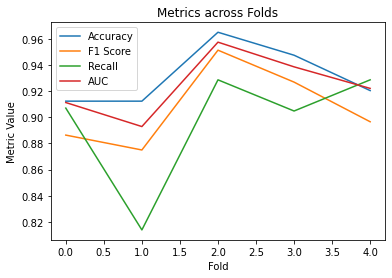

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import time

#  a self-implemented Naive Bayes classifier
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    # fit the model given training set X and y
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0)
            self.priors[c] = X_c.shape[0] / float(X.shape[0])

    # predict the class of the testing set X
    def predict(self, X):
        posteriors = []
        
        for c in self.classes:
            prior = np.log(self.priors[c])
            posterior = np.sum(np.log(self.gaussian(X, self.mean[c], self.var[c])))
            posterior = prior + posterior
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

    # calculate the gaussian value
    def gaussian(self, X, mean, var):
        eps = 1e-4
        return 1. / np.sqrt(2 * np.pi * var + eps) * np.exp(-1. * (X - mean) ** 2 / (2 * var + eps))
        
# convert target labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# initialize 
nb = NaiveBayes()

# start the timer
start_time = time.time()

# 5-fold cross validation
skf = StratifiedKFold(n_splits=5)

accuracy = []
f1 = []
recall = []
auc = []

# evaluate the the NB classifier
for train_index, test_index in skf.split(X, y):
    train_mask = np.zeros(len(X), dtype=bool)
    train_mask[train_index] = True
    test_mask = np.zeros(len(X), dtype=bool)
    test_mask[test_index] = True
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    nb.fit(X_train, y_train)
    
    y_pred = [nb.predict(x) for x in X_test.values]
    
    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))

# end the timer
end_time = time.time()
total_runtime = end_time - start_time

print("Avg Accuracy: ", np.mean(accuracy))    
print("Avg F1 score: ", np.mean(f1))
print("Avg Recall: ", np.mean(recall))
print("Avg AUC: ", np.mean(auc))
print(f"Total Runtime: {total_runtime:.2f} seconds")

# print the standard error of the metrics
print("Standard Error of Accuracy: ", np.std(accuracy) / np.sqrt(5))
print("Standard Error of F1 score: ", np.std(f1) / np.sqrt(5))
print("Standard Error of Recall: ", np.std(recall) / np.sqrt(5))
print("Standard Error of AUC: ", np.std(auc) / np.sqrt(5))


# plot metrics
plt.figure()
plt.plot(accuracy, label='Accuracy')
plt.plot(f1, label='F1 Score')
plt.plot(recall, label='Recall')
plt.plot(auc, label='AUC')
plt.legend()
plt.title("Metrics across Folds")
plt.xlabel("Fold")
plt.ylabel("Metric Value")
plt.show()